# Low price to FCF strategy evaluation

Is simply buying very low price to FCF (TTM) a good strategy?

By simply selecting lowest 10 stocks in price to FCF(TTM) ratio and hold it for 3 months, it seems to be consistently beating SPX. I applied some basic filtering:

1. Exclude REITs
2. Exclude stocks with negative FCF for any last 4 quarters
3. Exclude stocks whose most recent FCF is less than the average of last 4 quarters

But I doubt they are necessary.

Another finding is that compensate for growth doesn't seem necessary. I think it's because those stocks are so cheap that 20% growth won't change much. There may be marginal effect. But given the win over SPX is so big, it doesn't seem worthwhile to explore.

What's left is trying filtering by debt ratio, profitability, etc.


In [2]:
from research.interday_trading import InterdayTrading
from fmp_data import Dataset, FMPPriceLoader

pl = FMPPriceLoader()
t = InterdayTrading('2024-01-02', '2024-01-15')

In [3]:
start_date = '2013-01-02'
end_date = (pd.to_datetime(start_date) + pd.DateOffset(months=3)).strftime('%Y-%m-%d')

d = t.build_features_for_date(pd.to_datetime(start_date).date())
x = d
x = d[~d['industry'].str.contains('REIT', case=False, na=False)]
x = x[(x.min_fcf > 0) & (x.last_fcf > x.free_cash_flow / 4)]

#x = x[(x.min_yoy > 0)]

x['rank'] = x.price_to_fcf
#x = x[x.price >= 10]
sym = x.symbol.to_list()
p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data
y = pd.merge(x, p[['symbol', 'end_price']], on='symbol', how = 'inner')
y['r'] = y.end_price / y.price - 1
spx_r = pl.get_price('^SPX', end_date) / pl.get_price('^SPX', start_date) - 1

portfolio = y.sort_values('rank').head(10)

print(f"Average return: {portfolio.r.mean()*100:.2f}%, SPX return: {spx_r*100:.2f}%, diff: {(portfolio.r.mean() - spx_r)*100:.2f}%")
y[['symbol', 'last_fcf', 'price_to_fcf', 'median_yoy', 'min_yoy', 'last_yoy', 'sector', 'industry', 'rank', 'r']].sort_values('rank').head(20)

2025-04-23 11:16:12,508 - Fetching price data for 5389 stocks on 2013-01-02


2025-04-23 11:16:13,249 - Retrieved prices for 2598 stocks
2025-04-23 11:16:13,249 - Calculating price-to-FCF ratios
2025-04-23 11:16:13,285 - Calculating revenue growth metrics
2025-04-23 11:16:16,142 - Calculating price momentum metrics
2025-04-23 11:16:16,143 - Calculating price momentum for 5389 stocks
2025-04-23 11:16:16,352 - Calculated price momentum for 2570 stocks
2025-04-23 11:16:16,352 - Merging feature data
2025-04-23 11:16:16,355 - Adding sector and industry information


Average return: 27.91%, SPX return: 7.37%, diff: 20.54%


,symbol,last_fcf,price_to_fcf,median_yoy,min_yoy,last_yoy,sector,industry,rank,r
120,DQ,9663.948826,0.000172,-0.588983,-0.645474,-0.645474,Technology,Semiconductor Equipment & Materials,0.000172,-0.239759
79,CG,24.442950,0.343587,-0.308645,-0.671342,15.404362,Financial Services,Asset Management,0.343587,0.195767
259,OSBC,0.759923,0.458496,0.005921,-0.173537,0.022636,Financial Services,Banks - Regional,0.458496,1.537815
101,CRESY,4.058494,0.516233,0.201642,0.120890,0.120890,Industrials,Conglomerates,0.516233,0.077156
236,MS-PA,3.428253,0.817665,-0.298884,-0.465326,-0.465326,Financial Services,Capital Markets,0.817665,0.196097
300,SLM,1.732759,0.930816,0.161414,-0.211883,0.388034,Financial Services,Credit Services,0.930816,0.168519
255,OMAB,5.440607,0.932284,0.087725,-0.176663,0.180743,Industrials,Airports & Air Services,0.932284,0.504029
68,CASH,5.655288,0.972414,0.141642,-0.087687,-0.087687,Financial Services,Banks—Regional,0.972414,0.181556
235,MS,3.428253,1.115551,-0.298884,-0.465326,-0.465326,Financial Services,Capital Markets,1.115551,0.108311
276,PRU,12.307749,1.225354,0.131138,-0.118858,-0.118858,Financial Services,Insurance - Life,1.225354,0.061700


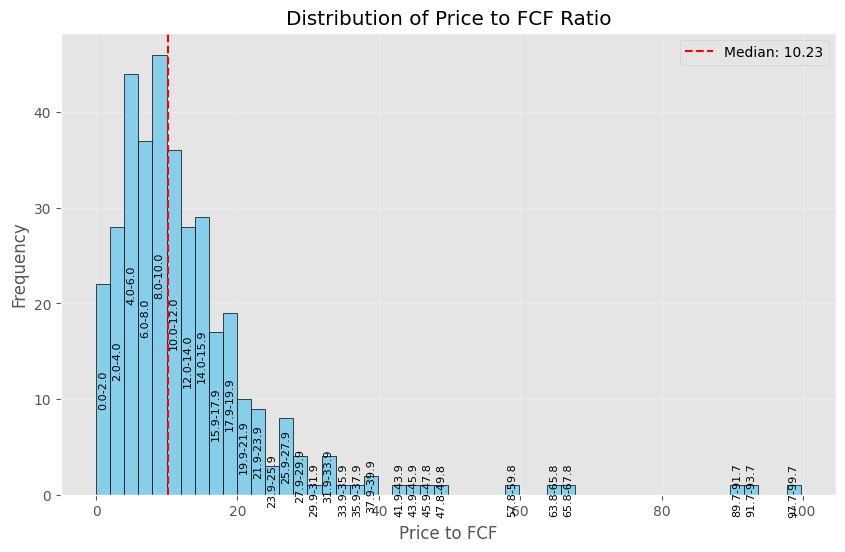

In [10]:
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(y[y.price_to_fcf < 100].price_to_fcf, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=y.price_to_fcf.median(), color='red', linestyle='--', label=f'Median: {y.price_to_fcf.median():.2f}')

# Add text labels showing the range for each bar
for i in range(len(patches)):
    if n[i] > 0:  # Only add text if the bar has data
        plt.text(bins[i] + (bins[i+1]-bins[i])/2, n[i]/2, 
                 f'{bins[i]:.1f}-{bins[i+1]:.1f}', 
                 ha='center', va='center', rotation=90, fontsize=8)

plt.title('Distribution of Price to FCF Ratio')
plt.xlabel('Price to FCF')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


/var/folders/wg/v69kcktn0jg6b4sv92_xtcrm0000gp/T/ipykernel_83372/4102888210.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bucket_returns = z.groupby(buckets)['r'].mean().reset_index()


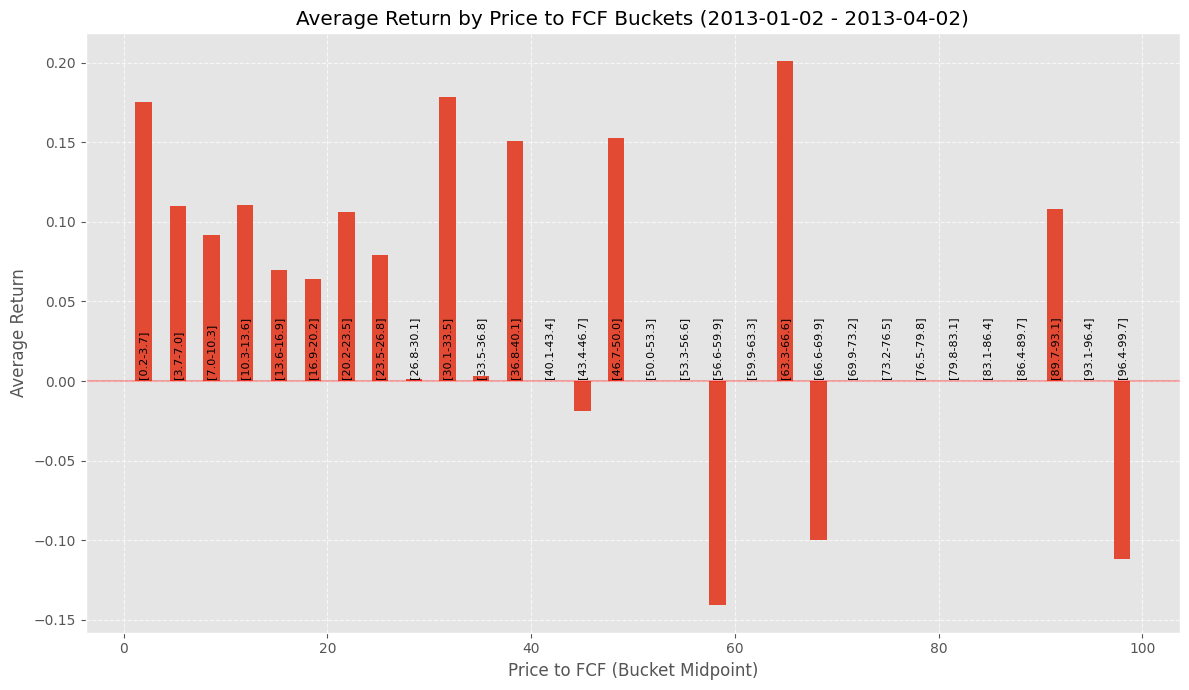

In [11]:
# Filter data to the specified range
z = y[(y.price_to_fcf >= 0.001) & (y.price_to_fcf <= 100)]

# Create 50 buckets
buckets = pd.cut(z.price_to_fcf, bins=30)

# Calculate average return for each bucket
bucket_returns = z.groupby(buckets)['r'].mean().reset_index()

# Get the bucket midpoints for x-axis
bucket_returns['midpoint'] = bucket_returns['price_to_fcf'].apply(lambda x: (x.left + x.right) / 2)

# Plot
plt.figure(figsize=(12, 7))
bars = plt.bar(bucket_returns['midpoint'], bucket_returns['r'], width=(100-0.001)/50*0.8)

# Add text labels for bucket boundaries
for i, bar in enumerate(bars):
    bucket = bucket_returns['price_to_fcf'].iloc[i]
    plt.text(bar.get_x() + bar.get_width()/2, 
             0.001, 
             f'[{bucket.left:.1f}-{bucket.right:.1f}]', 
             ha='center', 
             va='bottom', 
             rotation=90, 
             fontsize=8)

plt.title(f'Average Return by Price to FCF Buckets ({start_date} - {end_date})')
plt.xlabel('Price to FCF (Bucket Midpoint)')
plt.ylabel('Average Return')
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()


## Does price momentum improve it?

According to a [research](https://journals.sagepub.com/doi/10.1177/0148558X221091803), momentum compensates the prediction power of free FCF. Specifically, they proposed to long high FCF & strong momentum stocks and short low FCF & negative momentum stocks. They claim this strategy has very good performance.

In [15]:
y[['symbol', 'price_to_fcf', 'min_monthly_return', 'three_month_return', 'r']]

,symbol,price_to_fcf,min_monthly_return,three_month_return,r
0,AAON,7.484372,-0.003431,0.115163,0.259897
1,AB,8.238262,0.004518,0.203971,0.236882
2,ABBV,5.649676,NaN,NaN,0.172908
3,ABEV,8.574697,0.029817,0.291284,-0.021314
4,ABT,5.333801,-0.075542,-0.046746,0.131816
...,...,...,...,...,...
356,XYL,14.623432,0.005467,0.097856,-0.006367
357,YUM,14.616051,-0.073895,0.015539,0.049793
358,YY,32.464867,NaN,NaN,0.214343
359,ZBH,11.542455,-0.032978,0.008963,0.115823


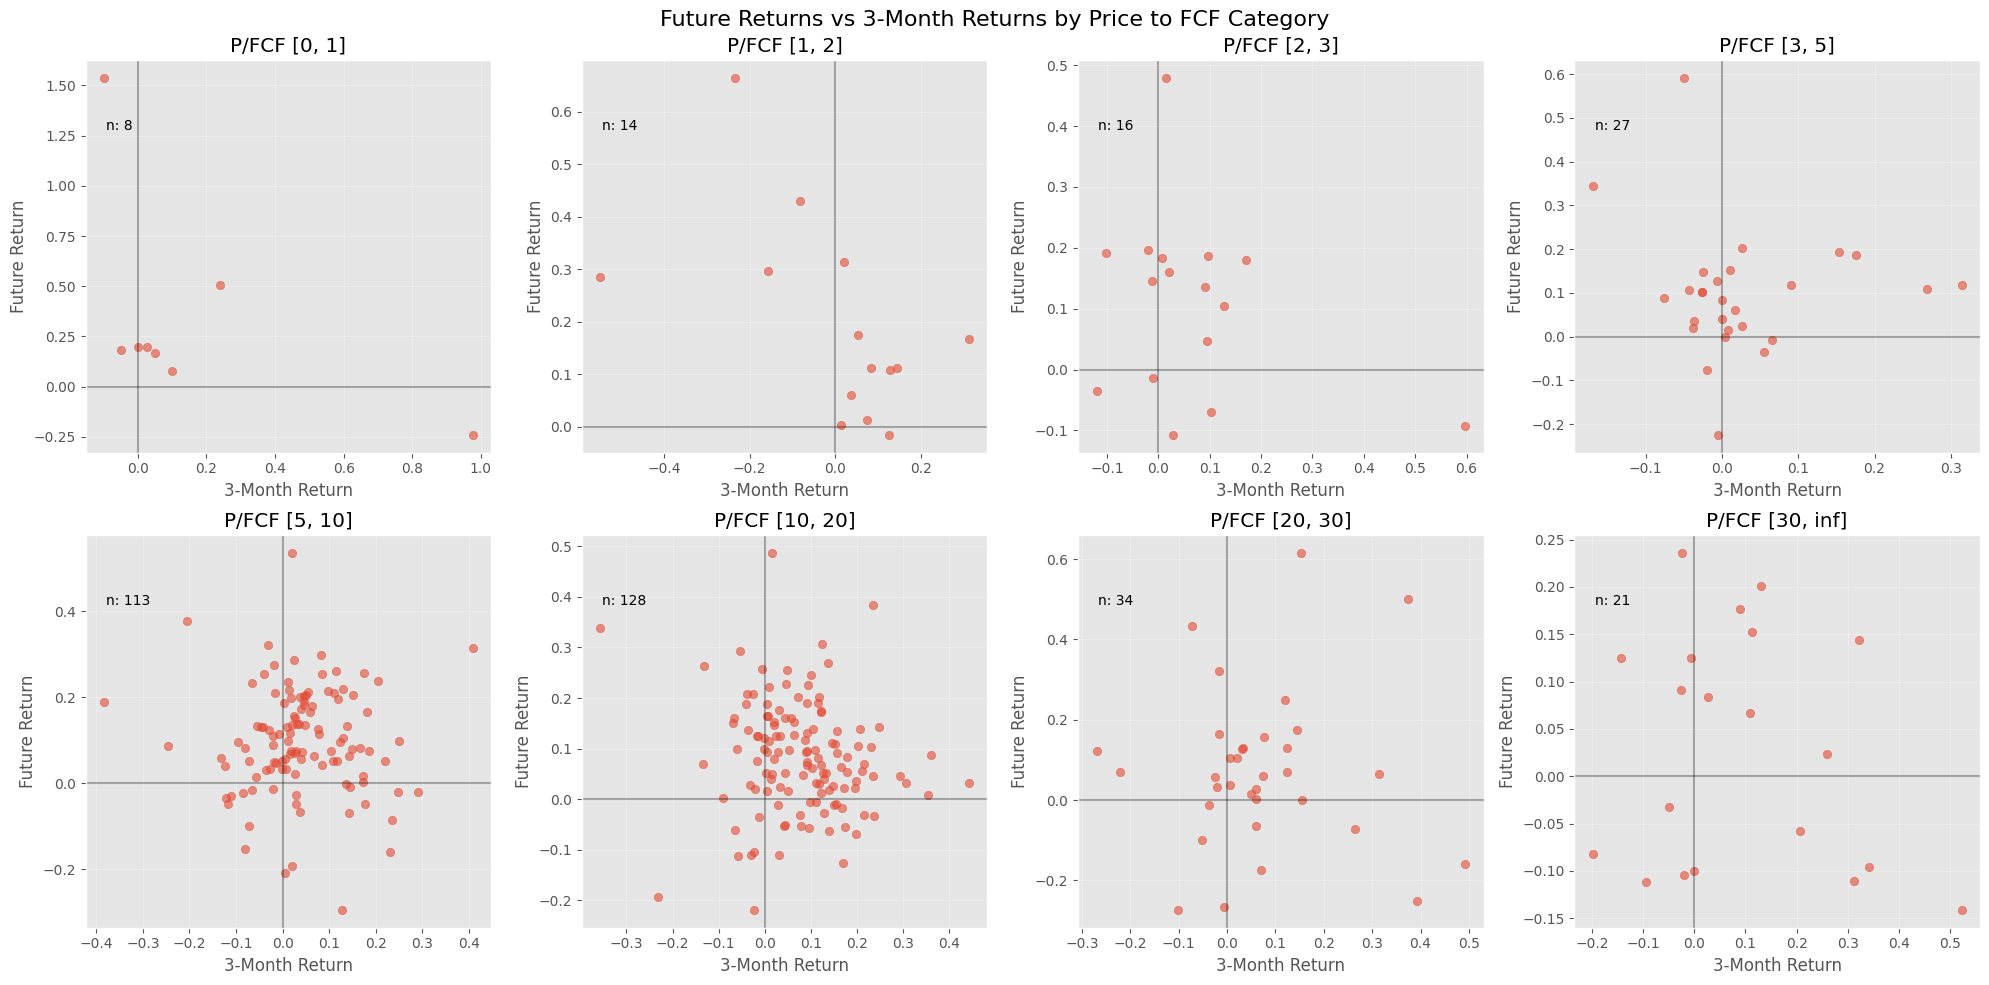

In [20]:
# Define the price to FCF categories
categories = [(0, 1), (1, 2), (2, 3), (3, 5), (5, 10), (10, 20), (20, 30), (30, float('inf'))]

# Create a figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

# Loop through each category
for i, (low, high) in enumerate(categories):
    # Filter data for this category
    category_data = y[(y.price_to_fcf >= low) & (y.price_to_fcf < high)]
    
    # Skip if no data
    if len(category_data) == 0:
        axs[i].text(0.5, 0.5, f"No data for P/FCF [{low}, {high}]", 
                   ha='center', va='center', transform=axs[i].transAxes)
        continue
    
    # Plot the data
    axs[i].scatter(category_data.three_month_return, category_data.r, alpha=0.6)
    
    # Add a trend line
    # if len(category_data) > 5:
    #     z = np.polyfit(category_data.three_month_return, category_data.r, 1)
    #     p = np.poly1d(z)
    #     x_range = np.linspace(category_data.three_month_return.min(), 
    #                          category_data.three_month_return.max(), 100)
    #     axs[i].plot(x_range, p(x_range), 'r--')
        
    # # Add correlation coefficient
    # if len(category_data) > 5:
    #     corr = category_data.three_month_return.corr(category_data.r)
    #     axs[i].text(0.05, 0.95, f"Corr: {corr:.2f}", transform=axs[i].transAxes,
    #                va='top', ha='left')
    
    # Add count
    axs[i].text(0.05, 0.85, f"n: {len(category_data)}", transform=axs[i].transAxes,
               va='top', ha='left')
    
    # Set title and labels
    axs[i].set_title(f"P/FCF [{low}, {high}]")
    axs[i].set_xlabel("3-Month Return")
    axs[i].set_ylabel("Future Return")
    axs[i].grid(True, alpha=0.3)
    axs[i].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axs[i].axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.suptitle("Future Returns vs 3-Month Returns by Price to FCF Category", fontsize=16)
plt.subplots_adjust(top=0.93)
plt.show()


In [31]:
x = d[~d['industry'].str.contains('REIT', case=False, na=False)]
x = x[(x.min_fcf > 0) & (x.last_fcf > x.free_cash_flow / 4)]

#x = x[(x.min_yoy > 0)]

x['rank'] = x.price_to_fcf
#x = x[x.price >= 10]
sym = x.symbol.to_list()
p = Dataset(sym, {'adjusted_close': 'end_price'}, for_date=end_date).data
y = pd.merge(x, p[['symbol', 'end_price']], on='symbol', how = 'inner')
y['r'] = y.end_price / y.price - 1
spx_r = pl.get_price('^SPX', end_date) / pl.get_price('^SPX', start_date) - 1

portfolio = y.sort_values('rank').head(5)

print(f"Average return: {portfolio.r.mean()*100:.2f}%, SPX return: {spx_r*100:.2f}%, diff: {(portfolio.r.mean() - spx_r)*100:.2f}%")
y[['symbol', 'last_fcf', 'price_to_fcf', 'median_yoy', 'min_yoy', 'last_yoy', 'sector', 'industry', 'rank', 'r']].sort_values('rank').head(20)

Average return: 35.34%, SPX return: 7.37%, diff: 27.97%


,symbol,last_fcf,price_to_fcf,median_yoy,min_yoy,last_yoy,sector,industry,rank,r
120,DQ,9663.948826,0.000172,-0.588983,-0.645474,-0.645474,Technology,Semiconductor Equipment & Materials,0.000172,-0.239759
79,CG,24.442950,0.343587,-0.308645,-0.671342,15.404362,Financial Services,Asset Management,0.343587,0.195767
259,OSBC,0.759923,0.458496,0.005921,-0.173537,0.022636,Financial Services,Banks - Regional,0.458496,1.537815
101,CRESY,4.058494,0.516233,0.201642,0.120890,0.120890,Industrials,Conglomerates,0.516233,0.077156
236,MS-PA,3.428253,0.817665,-0.298884,-0.465326,-0.465326,Financial Services,Capital Markets,0.817665,0.196097
300,SLM,1.732759,0.930816,0.161414,-0.211883,0.388034,Financial Services,Credit Services,0.930816,0.168519
255,OMAB,5.440607,0.932284,0.087725,-0.176663,0.180743,Industrials,Airports & Air Services,0.932284,0.504029
68,CASH,5.655288,0.972414,0.141642,-0.087687,-0.087687,Financial Services,Banks—Regional,0.972414,0.181556
235,MS,3.428253,1.115551,-0.298884,-0.465326,-0.465326,Financial Services,Capital Markets,1.115551,0.108311
276,PRU,12.307749,1.225354,0.131138,-0.118858,-0.118858,Financial Services,Insurance - Life,1.225354,0.061700
